In [1]:
import sys
print(sys.executable)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from Bio import SeqIO
from Bio import AlignIO
from itertools import zip_longest
from skbio import DistanceMatrix
from skbio.tree import nj
import ete3

/Users/aviv/opt/miniconda3/bin/python3.7


In [2]:
# 20 random sequences
#rand_seqs = SeqIO.parse("sequences.fasta", "fasta")
#rand_seqs = [repr(s.seq) for s in rand_seqs]
#print(rand_seqs)

# NOT ALIGNED 20 curated sequences (2 from each region, corresponding to the oldest and newest seqences)
cur_seq_dict = SeqIO.to_dict(SeqIO.parse("curated_sequences.fasta", "fasta"))
seq_records = list(cur_seq_dict.values())

metadata_df = pd.read_csv('curated_sequences_metadata.csv',sep=',',index_col='Accession')
acc_nrs = metadata_df.index.values
locs = metadata_df.Geo_Location.values
dates = metadata_df.Collection_Date.values
seq_labels = acc_nrs + '_' + locs + '_'+ dates
seq_labels = [str(i).replace(":", '_').replace(" ", '_').replace(",", '_') for i in seq_labels]
print(f'labels:\n{seq_labels}\n')


# showing how a single record looks like
print(f'seq_record:\n{seq_records[0]}\n')
print(f'seq:\n{seq_records[0].seq}\n')

labels:
['NC_045512_China_2019-12', 'MN985325_USA_2020-01-19', 'MT007544_Australia__Melbourne__Victoria_2020-01-25', 'MT126808_Brazil_2020-02-28', 'MT066156_Italy_2020-01-30', 'MT198652_Spain__Valencia_2020-03-05', 'MT276597_Israel_2020-02', 'MT276598_Israel_2020-03', 'MT350282_Brazil_2020-03-18', 'MT318827_Germany_2020-03-19', 'MT513758_Morocco_2020-04-23', 'MT568645_Morocco__Casablanca_2020-05-15', 'MT582453_Germany__Dusseldorf_2020-03-20', 'MT510690_Egypt_2020-05-02', 'MT627325_China_2020-02-28', 'MT641645_Australia__Northern_Territory_2020-02-21', 'MT655131_Spain__Donostia-San_Sebatian_2020-03-25', 'MT627396_Egypt_2020-06-02', 'MT682732_Italy_2020-04-20', 'MT703677_USA__NY_2020-03-11']

seq_record:
ID: NC_045512.2
Name: NC_045512.2
Description: NC_045512.2 |Severe acute respiratory syndrome coronavirus 2 isolate Wuhan-Hu-1, complete genome|China
Number of features: 0
Seq('ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTCGATCTCTTGT...AAA', SingleLetterAlphabet())

seq:
ATTAAAGGTTTATACCTT

In [3]:
def seq_to_2d(input_seq,m,n):
    x = np.zeros(len(input_seq)+1)
    y = np.zeros(len(input_seq)+1)
    for i, base in enumerate(input_seq):
        if base == 'A':
            x[i+1] = x[i] + m
            y[i+1] = y[i] - n**(1/2)
        elif base == 'C':
            x[i+1] = x[i] + n**(1/2)
            y[i+1] = y[i] + m
        elif base == 'G':
            x[i+1] = x[i] + n**(1/2)
            y[i+1] = y[i] - m
        elif base == 'T':
            x[i+1] = x[i] + m
            y[i+1] = y[i] + n**(1/2)
        elif base == 'N':
            x[i+1] = x[i] + (1/2)*(m + n**(1/2)) # could be any -> avg of A/C/G/T_x
            y[i+1] = y[i]  # could be any -> no change
        elif base == 'K': # G or T
            x[i+1] = x[i] + (1/2)*(n**(1/2) + m) # avg of G_x and T_x
            y[i+1] = y[i] + (1/2)*(n**(1/2) - m) # avg of G_y and T_y
        elif base == 'Y': # C or T
            x[i+1] = x[i] + (1/2)*(n**(1/2) + m) # avg of C_x and T_x
            y[i+1] = y[i] + (1/2)*(n**(1/2) + m) # avg of C_y and T_y
        elif base == 'R': # A or G
            x[i+1] = x[i] + (1/2)*(m + n**(1/2)) # avg of A_x and G_x
            y[i+1] = y[i] + (1/2)*(-m - n**(1/2)) # avg of A_y and G_y 
        elif base == 'M': # A or C
            x[i+1] = x[i] + (1/2)*(m + n**(1/2)) # avg of A_x and C_x
            y[i+1] = y[i] + (1/2)*(m - n**(1/2)) # avg of A_y and C_y
        elif base == '-': # when indel
            x[i+1] = x[i]
            y[i+1] = y[i]
        else:
            raise ValueError(f'Unexpected base: {base}')
    return x,y

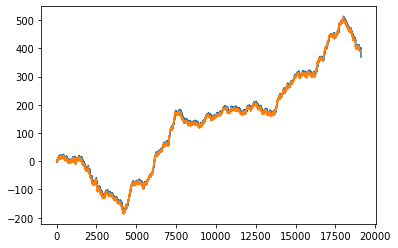

In [4]:
m = 1/2
n = 3/4

seq_data_curves = []
for seq_rec in seq_records:
    seq_data_curves.append(seq_to_2d(seq_rec.seq,m,n))
    
first_curve = seq_data_curves[0]
sixth_curve = seq_data_curves[5]
plt.plot(*first_curve)
plt.plot(*sixth_curve)


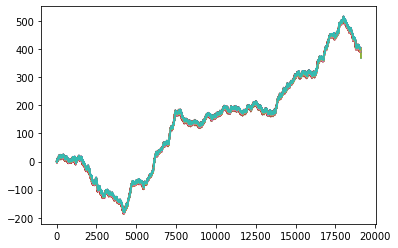

In [5]:
for cur in seq_data_curves:
    plt.plot(*cur,alpha=0.8)

In [6]:
def calc_geocenter(x_vect,y_vect):
    x_0 = np.mean(x_vect)
    y_0 = np.mean(y_vect)
    return x_0, y_0

def get_EV_pair(x_vect,y_vect):
    xy_vec = np.stack((x_vect, y_vect), axis = 0) 
    cm = np.cov(xy_vec)
    _ , EV_matrix = np.linalg.eig(cm)
    EV_1, EV_2 = EV_matrix[:,0], EV_matrix[:,1]
    return EV_1, EV_2

In [7]:
print(calc_geocenter(*sixth_curve))
print(get_EV_pair(*sixth_curve))

(9507.1535596009, 135.51887315858116)
(array([0.99955831, 0.02971854]), array([-0.02971854,  0.99955831]))


In [8]:
# form https://stackoverflow.com/questions/2827393/angles-between-two-n-dimensional-vectors-in-python (David Wolever)

import numpy as np

def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

In [9]:
def calc_d_ij(curve_i, curve_j):
    x_i_0, y_i_0 = calc_geocenter(*curve_i)
    x_j_0, y_j_0 = calc_geocenter(*curve_j)
    d_ij = ((x_i_0-x_j_0)**(2) +(y_i_0-y_j_0)**(2))**(1/2)
    return d_ij

def calc_theta_ij(curve_i, curve_j):
    EV_i_0, EV_i_1 = get_EV_pair(*curve_i)
    EV_j_0, EV_j_1 = get_EV_pair(*curve_j)
    
    thata_ij_0 = angle_between(EV_i_0,EV_j_0)
    theta_ij_1 = angle_between(EV_j_0,EV_j_1)
    return thata_ij_0+theta_ij_1

def calc_D_matrix(list_of_curves):
    dim = len(list_of_curves)
    D_matrix = np.zeros((dim,dim))
    for i in range(len(list_of_curves)):
        for j in range(len(list_of_curves)):
            d_ij = calc_d_ij(list_of_curves[i], list_of_curves[j])
            theta_ij = calc_theta_ij(list_of_curves[i], list_of_curves[j])
            D_matrix[i,j] = d_ij*theta_ij
    return D_matrix

In [10]:
all_seq_D_matrix = calc_D_matrix(seq_data_curves)

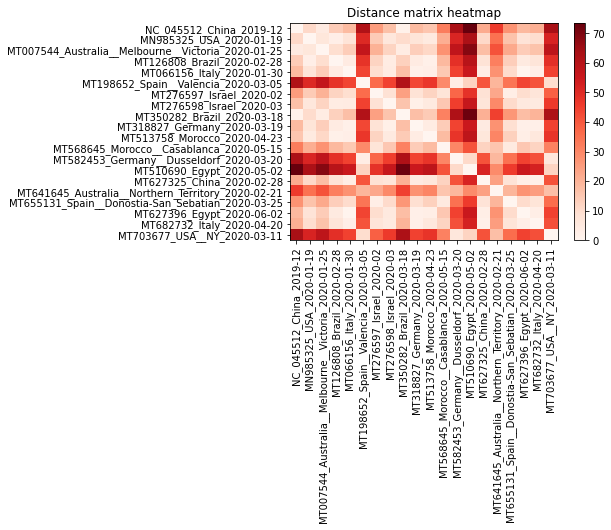

In [11]:
dm = DistanceMatrix(all_seq_D_matrix, seq_labels)
fig = dm.plot(cmap='Reds', title='Distance matrix heatmap')

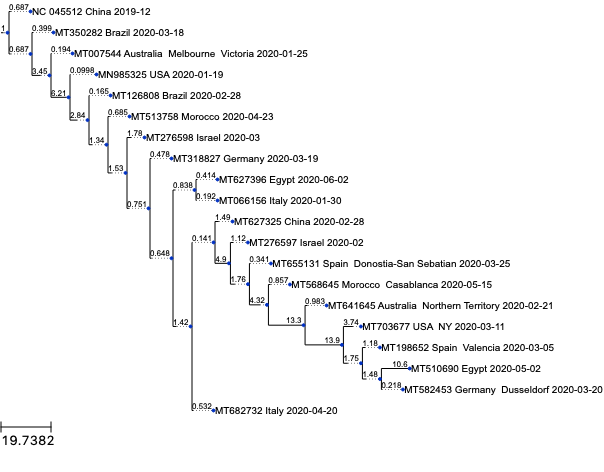

In [12]:
tree = nj(dm)
ts = ete3.TreeStyle()
ts.show_branch_length = True
et_tree = ete3.TreeNode.from_skbio(tree)
et_tree.set_outgroup('NC 045512 China 2019-12')
et_tree.render("%%inline", tree_style=ts)

### now lets try to see the difference when we use alligned sequences

In [13]:
# the ALIGNED (MSA) 20 curated seq:
aln_cur_seq_recs = AlignIO.read("curated_sequences_aligned.aln", "clustal")

# reorder the lists based on the non-aligned seq position order
acc_nr_of_rec_no_period = lambda rec : rec.id.split('.')[0]
acc_nr_ordered_index = lambda acc_nr : list(acc_nrs).index(acc_nr)
ordered_aln_cur_seq_recs = [0 for i in range(len(aln_cur_seq_recs))]
for i,rec in enumerate(aln_cur_seq_recs):
    acc_nr = acc_nr_of_rec_no_period(rec)
    ordered_index = acc_nr_ordered_index(acc_nr)
    ordered_aln_cur_seq_recs[ordered_index] = rec

alned_seq_list = [rec.seq for rec in ordered_aln_cur_seq_recs]

In [14]:
# for clipping the sequences to same length (min. complete coverage)

def get_clipping_indexes(list_of_aligned_seqs):
    index_of_first_common_letter = None 
    index_of_last_common_letter = None
    for s in list_of_aligned_seqs:
        index_of_first_letter = None
        for i,base in enumerate(s):
            if (base != '-'):
                index_of_first_letter = i
                break
        index_of_last_letter = None
        rev_seq = ''.join(reversed(s))
        last_index = len(rev_seq) - 1
        for i,base in enumerate(rev_seq):
            if (base != '-'):
                index_of_last_letter = last_index - i
                break
        if (index_of_first_common_letter == None or index_of_first_common_letter < index_of_first_letter):
            index_of_first_common_letter = index_of_first_letter
        elif (index_of_last_common_letter == None or index_of_last_common_letter > index_of_last_letter):
            index_of_last_common_letter = index_of_last_letter
    return index_of_first_common_letter,index_of_last_common_letter
            
'''
# testing 
a = '---ATTCGGAGG---'
b = '-AAATTCCGA-----'
clipping_indexes = get_clipping_indexes([a,b])
clipped_a, clipped_b = a[clipping_indexes[0]:clipping_indexes[1]] , b[clipping_indexes[0]:clipping_indexes[1]]
print(clipping_indexes)
print(clipped_a, clipped_b)
# should print (3,9) -> clipped_a = 'ATTCGGA', clipped_b = 'ATTCCGA'
'''

start_clip_i, end_clip_i = get_clipping_indexes(alned_seq_list)
clipped_alned_seq = [seq[start_clip_i:end_clip_i] for seq in alned_seq_list]
print(clipped_alned_seq[0])
print([len(seq) for seq in clipped_alned_seq])

GTTCTCTAAACGAACTTTAAAATCTGTGTGGCTGTCACTCGGCTGCATGCTTAGTGCACTCACGCAGTATAATTAATAACTAATTACTGTCGTTGACAGGACACGAGTAACTCGTCTATCTTCTGCAGGCTGCTTACGGTTTCGTCCGTGTTGCAGCCGATCATCAGCACATCTAGGTTTCGTCCGGGTGTGACCGAAAGGTAAGATGGAGAGCCTTGTCCCTGGTTTCAACGAGAAAACACACGTCCAACTCAGTTTGCCTGTTTTACAGGTTCGCGACGTGCTCGTACGTGGCTTTGGAGACTCCGTGGAGGAGGTCTTATCAGAGGCACGTCAACATCTTAAAGATGGCACTTGTGGCTTAGTAGAAGTTGAAAAAGGCGTTTTGCCTCAACTTGAACAGCCCTATGTGTTCATCAAACGTTCGGATGCTCGAACTGCACCTCATGGTCATGTTATGGTTGAGCTGGTAGCAGAACTCGAAGGCATTCAGTACGGTCGTAGTGGTGAGACACTTGGTGTCCTTGTCCCTCATGTGGGCGAAATACCAGTGGCTTACCGCAAGGTTCTTCTTCGTAAGAACGGTAATAAAGGAGCTGGTGGCCATAGTTACGGCGCCGATCTAAAGTCATTTGACTTAGGCGACGAGCTTGGCACTGATCCTTATGAAGATTTTCAAGAAAACTGGAACACTAAACATAGCAGTGGTGTTACCCGTGAACTCATGCGTGAGCTTAACGGAGGGGCATACACTCGCTATGTCGATAACAACTTCTGTGGCCCTGATGGCTACCCTCTTGAGTGCATTAAAGACCTTCTAGCACGTGCTGGTAAAGCTTCATGCACTTTGTCCGAACAACTGGACTTTATTGACACTAAGAGGGGTGTATACTGCTGCCGTGAACATGAGCATGAAATTGCTTGGTACACGGAACGTTCTGAAAAGAGCTATGAATTGCAGACACCTTTTGAAATTAAATTGGCAAAGAAATTTGACACC

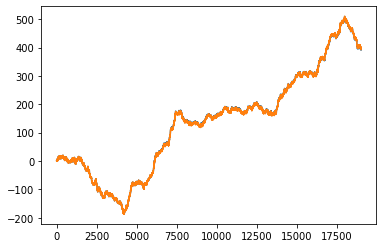

In [15]:
aligned_seq_data_curves = []
for seq in clipped_alned_seq:
    aligned_seq_data_curves.append(seq_to_2d(seq,m,n))
    
first_curve = aligned_seq_data_curves[0]
sixth_curve = aligned_seq_data_curves[5]
plt.plot(*first_curve)
plt.plot(*sixth_curve)

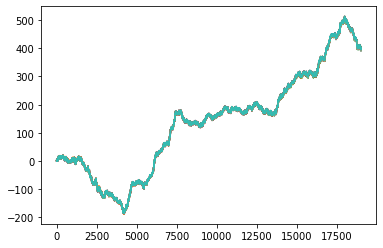

In [16]:
for cur in aligned_seq_data_curves:
    plt.plot(*cur,alpha=0.8)

In [17]:
all_alned_seq_D_matrix = calc_D_matrix(aligned_seq_data_curves)

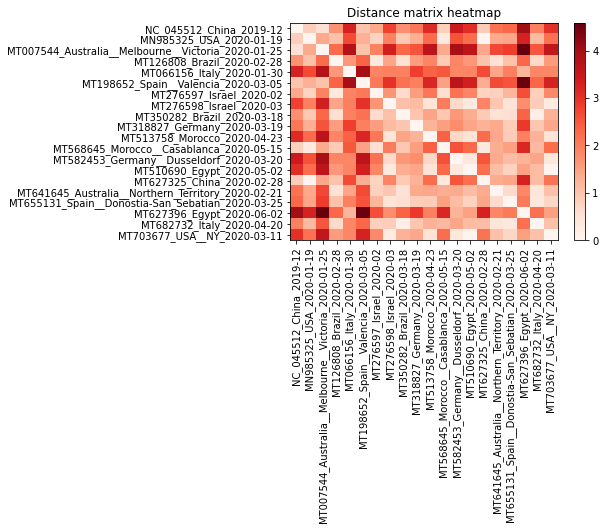

In [18]:
dm = DistanceMatrix(all_alned_seq_D_matrix, seq_labels)
fig = dm.plot(cmap='Reds', title='Distance matrix heatmap')


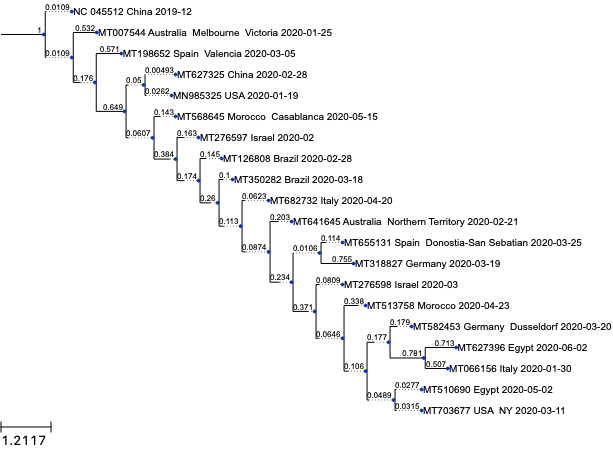

In [19]:
tree = nj(dm)
ts = ete3.TreeStyle()
ts.show_branch_length = True
et_tree = ete3.TreeNode.from_skbio(tree)
et_tree.set_outgroup('NC 045512 China 2019-12')
et_tree.render("%%inline", tree_style=ts)